In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from tbats import TBATS, BATS
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [68]:
#read data
df = pd.read_csv(r'C:\Users\I539797\Documents\Thesis\Datasets\Formatted Datasets\formatted_pittsburgh.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.head()

,NumericIndex,OriginMovementID,DestinationMovementID,MeanTravelTimeSeconds,RangeLowerBoundTravelTimeSeconds,RangeUpperBoundTravelTimeSeconds,DayOfWeek
Date,,,,,,,
2016-01-02,361878,411,611,999,828,1205,Saturday
2016-01-02,361772,411,330,261,163,415,Saturday
2016-01-02,361771,411,329,364,215,615,Saturday
2016-01-02,361770,411,326,273,152,487,Saturday
2016-01-02,361769,411,324,300,166,539,Saturday


In [69]:
y = pd.DataFrame(df.groupby('Date')['MeanTravelTimeSeconds'].mean()[:-90])
y.head()

,MeanTravelTimeSeconds
Date,
2016-01-02,558.903030
2016-02-02,562.397351
2016-02-03,578.457746
2016-02-04,655.517007
2016-02-05,608.027174


Text(0.5, 1.0, 'Time Series Data')

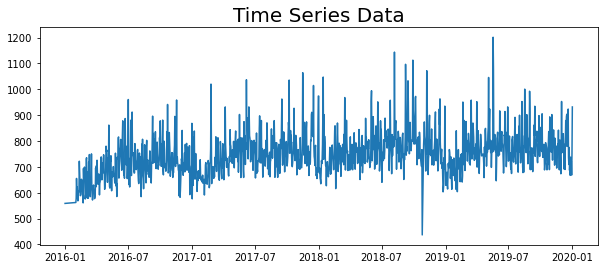

In [70]:
plt.figure(figsize=(10,4))
plt.plot(y)
plt.title('Time Series Data', fontsize=20)

In [6]:
y_to_train = y.iloc[:(len(y)-365)]
y_to_test = y.iloc[(len(y)-365):]

## TBATS

In [62]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 30.5))
model = estimator.fit(y_to_train)

# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

In [63]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 7.  30.5]
Seasonal harmonics [2 1]
ARMA errors (p, q): (2, 3)
Smoothing (Alpha): 0.062945
Seasonal Parameters (Gamma): [-1.05872761e-05  1.69382929e-06 -3.23830194e-07 -9.93230054e-06]
AR coefficients [-3.23830194e-07 -9.93230054e-06]
MA coefficients [0.2934698  0.09915563 0.05169149]
Seed vector [ 5.60553704e+02  6.65444851e+00  4.63907104e-01 -1.15765186e+01
 -3.65258617e+00  1.32866134e+00 -4.25553921e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

AIC 15765.663218


In [64]:
#get the predictions and residuals
predictions = pd.Series(y_forecast, index=y_to_test.index)
residuals = y_to_test - predictions

Text(0, 0.5, 'Seconds')

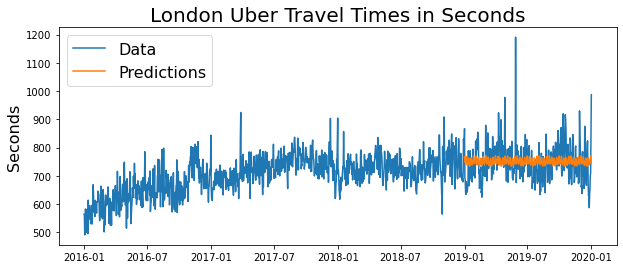

In [65]:
plt.figure(figsize=(10,4))

plt.plot(y)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('London Uber Travel Times in Seconds', fontsize=20)
plt.ylabel('Seconds', fontsize=16)
# for year in range(start_date.year,end_date.year):
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [66]:
# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_to_test, predictions): 
    y_to_test, predictions = np.array(y_to_test), np.array(predictions)
    return np.mean(np.abs((predictions - y_to_test)/y_to_test)) * 100

mean_absolute_percentage_error(y_to_test, predictions)

6.842403944647274

In [67]:
# Root Mean Square Error (RMSE)
def rmse(y_to_test, predictions):
    y_to_test, predictions = np.array(y_to_test), np.array(predictions)
    return np.sqrt(np.mean((predictions - y_to_test)**2))

rmse(y_to_test, predictions)

66.94372838360161

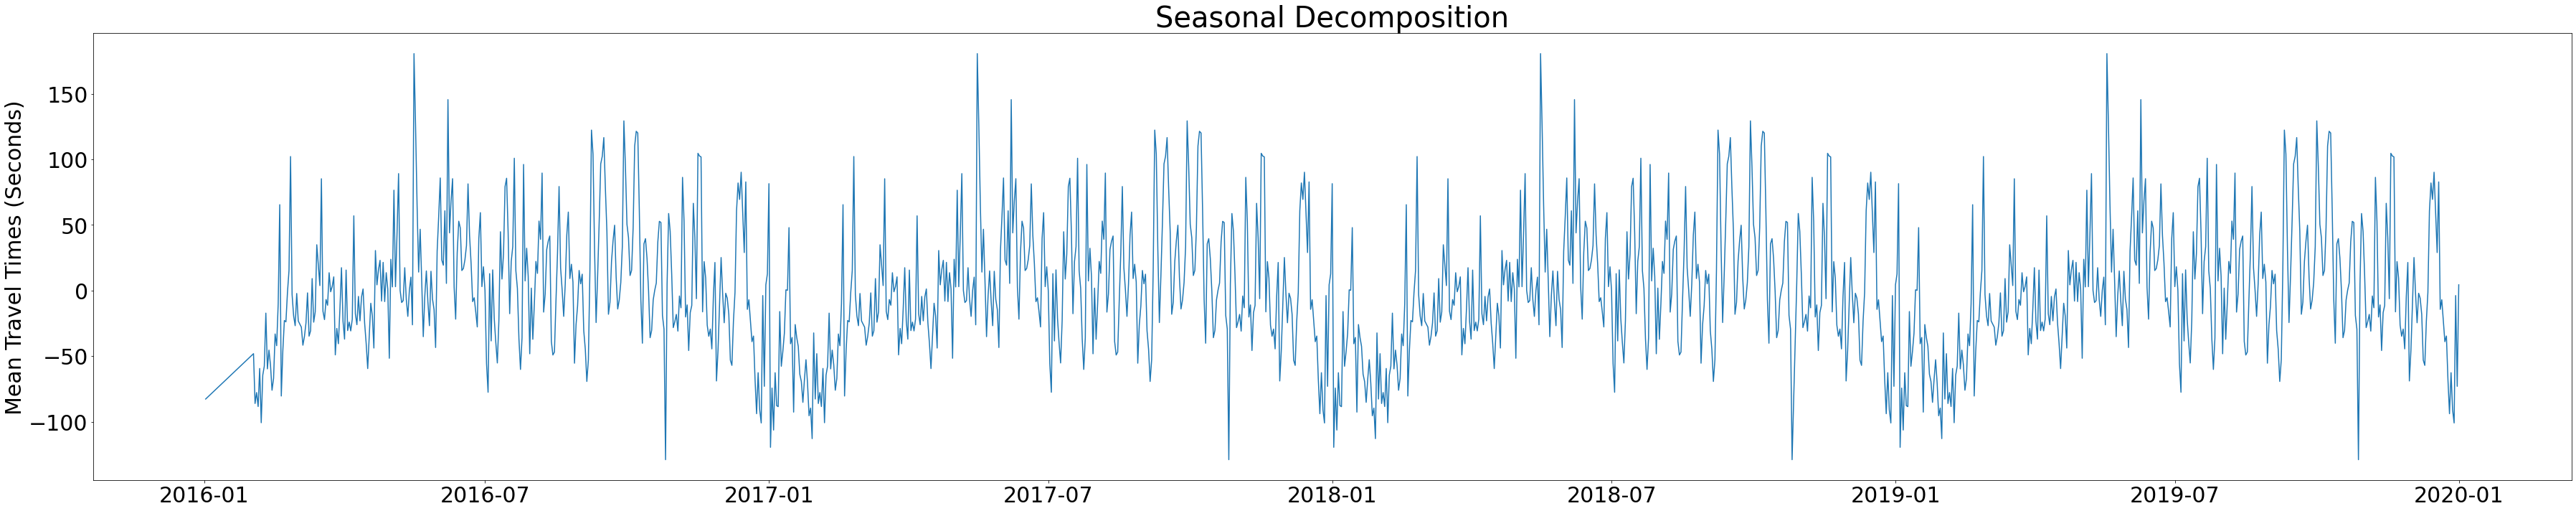

In [71]:
# Plotting trend, seasonality and residuals
decomposition = seasonal_decompose(y, model='additive', period=365)
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax1 = plt.subplots(1, figsize=(50,10))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax1.plot(y.index.unique(), seasonal)
ax1.set_title("Seasonal Decomposition", fontsize=40)
ax1.set_ylabel("Mean Travel Times (Seconds)", fontsize=30)

# ax2.plot(y.index.unique(), seasonal)
# ax2.set_title("Seasonal", fontsize=40)

# ax3.plot(y.index.unique(), residual)
# ax3.set_title("Residual", fontsize=40)

fig.tight_layout()
plt.show()

In [ ]:
predictions_rolling = pd.Series()
for end_date in y_to_test.index:
    y_to_train = df[:end_date - timedelta(days=1)]
    model = TBATS(seasonal_periods=(7, 30.5))
    model_fit = model.fit(y_to_train)
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[enda_date] = pred.loc[end_date]